In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
    
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dissolved-oxygen-prediction-in-river-water/train.csv
/kaggle/input/dissolved-oxygen-prediction-in-river-water/test.csv
/kaggle/input/playground-series-s3e21/sample_submission.csv


# Description of Original Dataset

Content
This dataset has data of the 5 indicators of river water quality from 8 consecutive stations of the state water monitoring system. It's should predict the value in the eighth station by the first seven stations. The numbering of stations in the dataset is done from the target station upstream, ie closest to it - first, upstream - second, etc.

Data are average monthly. The number of observations on stations is different (from 4 to about 20 years).

Training and test data are chosen so that the percentage of non-NA values on stations with long and short series data is approximately the same. Test data do not contain target column, as in the future it is planned to organize a competition to predict this data.

Indicators of river water quality in this dataset are:

Dissolved oxygen (O2) is measured in mgO2/cub. dm (ie milligrams of oxygen (O2) in the cubic decimeter);

Ammonium ions (NH4) concentration is measured in mg/cub. dm (ie milligrams in the cubic decimeter);

Nitrite ions (NO2) concentration is measured in mg/cub. dm (ie milligrams in the cubic decimeter);

Nitrate ions (NO3) concentration is measured in mg/cub. dm (ie milligrams in the cubic decimeter);

Biochemical oxygen demand, which is determined in 5 days ("BOD5" or "BOD"). BOD5 is measured in mgO/cub. dm (ie milligrams of oxygen in the cubic decimeter).

The minimum permissible value of O2 in Ukraine is 4 mgO2/cub. dm.

Id - the unique id of a given monthly averaged data;

target - a values of monthly averaged data of O2 in target station, mgO2/cub. dm;

1-7 - a values of monthly averaged data in stations 1-7 (in seven stations located from the target station upstream)

# EDA

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')
df.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


In [3]:
og_train = pd.read_csv('/kaggle/input/dissolved-oxygen-prediction-in-river-water/train.csv')
og_test = pd.read_csv('/kaggle/input/dissolved-oxygen-prediction-in-river-water/test.csv')
og_train.head(-5)

,Id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,12.58,9.875,9.200,NaN,NaN,NaN,NaN,NaN,0.690,...,NaN,NaN,NaN,4.80,5.850,NaN,NaN,NaN,NaN,NaN
1,3,9.37,10.300,10.750,NaN,NaN,NaN,NaN,NaN,0.710,...,NaN,NaN,NaN,5.88,6.835,NaN,NaN,NaN,NaN,NaN
2,4,8.35,8.290,7.900,NaN,NaN,NaN,NaN,NaN,2.210,...,NaN,NaN,NaN,3.20,2.700,NaN,NaN,NaN,NaN,NaN
3,5,9.57,8.820,6.800,NaN,NaN,NaN,NaN,NaN,0.595,...,NaN,NaN,NaN,7.70,7.055,NaN,NaN,NaN,NaN,NaN
4,6,6.00,6.000,6.500,NaN,NaN,NaN,NaN,NaN,0.600,...,NaN,NaN,NaN,5.50,5.300,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,202,9.50,9.700,8.900,9.545,8.37,6.025,9.805,5.03,1.490,...,4.58,1.73,0.76,2.52,1.720,4.725,6.075,5.725,2.95,7.37
138,203,10.25,9.150,8.565,NaN,NaN,NaN,NaN,NaN,0.310,...,NaN,NaN,NaN,4.25,4.800,NaN,NaN,NaN,NaN,NaN
139,204,8.60,4.900,7.100,9.500,5.24,1.340,8.980,6.94,0.520,...,2.23,0.82,1.78,3.10,4.000,8.000,9.250,7.900,5.10,7.50
140,205,5.20,3.100,6.600,NaN,NaN,NaN,NaN,NaN,0.160,...,NaN,NaN,NaN,8.00,7.400,NaN,NaN,NaN,NaN,NaN


In [4]:
og_test.head()

,Id,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,1,10.90,10.60,NaN,NaN,NaN,NaN,NaN,0.63,0.600,...,NaN,NaN,NaN,6.80,5.40,NaN,NaN,NaN,NaN,NaN
1,2,13.15,12.62,NaN,NaN,NaN,NaN,NaN,1.50,0.870,...,NaN,NaN,NaN,4.71,4.20,NaN,NaN,NaN,NaN,NaN
2,32,3.80,6.50,NaN,NaN,NaN,NaN,NaN,0.32,0.540,...,NaN,NaN,NaN,2.10,3.40,NaN,NaN,NaN,NaN,NaN
3,40,10.45,10.65,NaN,NaN,NaN,NaN,NaN,1.38,1.635,...,NaN,NaN,NaN,5.35,5.85,NaN,NaN,NaN,NaN,NaN
4,43,8.10,8.10,NaN,NaN,NaN,NaN,NaN,1.72,1.680,...,NaN,NaN,NaN,4.80,5.30,NaN,NaN,NaN,NaN,NaN


In [5]:
data = [df,og_train,og_test]
missing = pd.DataFrame()
for set in data:
    compare = pd.Series(set.isnull().sum()*100/set.shape[0])
    missing = pd.concat([missing,compare], axis = 1)
missing.columns = ['Submission', 'Original Train', 'Original Test']
missing

,Submission,Original Train,Original Test
id,0.0,NaN,NaN
target,0.0,0.000000,NaN
O2_1,0.0,1.360544,0.000000
O2_2,0.0,1.360544,0.000000
O2_3,0.0,78.231293,76.190476
O2_4,0.0,78.911565,76.190476
O2_5,0.0,77.551020,74.603175
O2_6,0.0,74.829932,77.777778
O2_7,0.0,74.829932,77.777778
NH4_1,0.0,1.360544,0.000000


* Id is labeled differently in contrived data.
* In many cases, 75% of original data is missing!
* Data collected closeset to target (1-2) are more reliable which should have the largest indicator of target value

# Iniate model and evaluation metric from competition

In [6]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
#Make Original Data Workable for model to compare cross validation scores
from sklearn.impute import SimpleImputer
impute = SimpleImputer(strategy = 'constant', fill_value = 0)
X_og = pd.DataFrame(impute.fit_transform(og_train), columns = impute.feature_names_in_)
X_og.head()

,Id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0.0,12.58,9.875,9.20,0.0,0.0,0.0,0.0,0.0,0.690,...,0.0,0.0,0.0,4.80,5.850,0.0,0.0,0.0,0.0,0.0
1,3.0,9.37,10.300,10.75,0.0,0.0,0.0,0.0,0.0,0.710,...,0.0,0.0,0.0,5.88,6.835,0.0,0.0,0.0,0.0,0.0
2,4.0,8.35,8.290,7.90,0.0,0.0,0.0,0.0,0.0,2.210,...,0.0,0.0,0.0,3.20,2.700,0.0,0.0,0.0,0.0,0.0
3,5.0,9.57,8.820,6.80,0.0,0.0,0.0,0.0,0.0,0.595,...,0.0,0.0,0.0,7.70,7.055,0.0,0.0,0.0,0.0,0.0
4,6.0,6.00,6.000,6.50,0.0,0.0,0.0,0.0,0.0,0.600,...,0.0,0.0,0.0,5.50,5.300,0.0,0.0,0.0,0.0,0.0


In [8]:
#Run initial test to see feature importanct of model
from sklearn.model_selection import train_test_split

X = df.drop(['id', 'target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

In [9]:
print(f"Score on Training Set:{rf.score(X_train,y_train)} ")
print(f"Score on Test Set:{rf.score(X_test,y_test)} ")

Score on Training Set:0.7669649410826389 
Score on Test Set:0.47197003595260734 


* Score on Test Set is much lower than training set, indicating overfitting

/tmp/ipykernel_19/1453178386.py:8: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


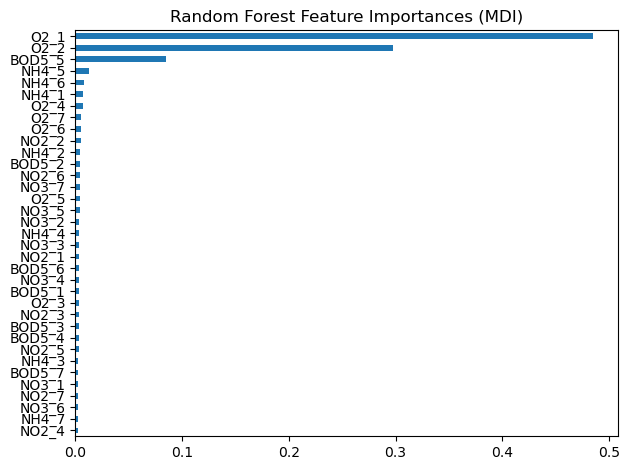

In [10]:
import matplotlib.pyplot as plt
importances = pd.Series(rf.feature_importances_, index=rf.feature_names_in_).sort_values(ascending=True)

fig, ax = plt.subplots()
ax = importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()
fig.tight_layout()

* Three best features from sample submission are O2_1, O2_2 and BOD5_5
* What about permutation importance

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


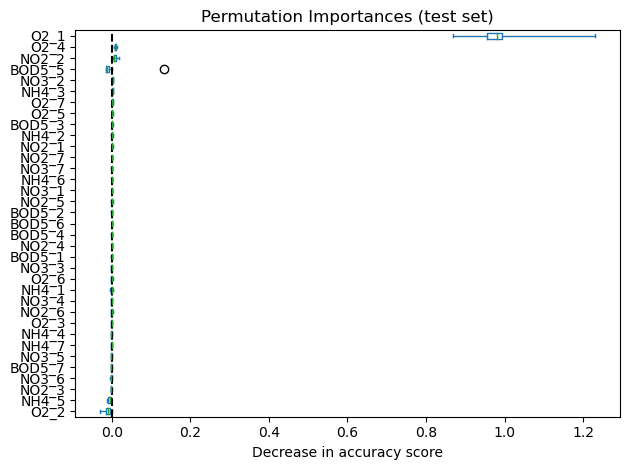

In [11]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [12]:
importances.mean().sort_values(ascending=False)

O2_1      1.004972
O2_4      0.009170
NO2_2     0.008458
BOD5_5    0.003242
NO3_2     0.002140
NH4_3     0.001977
O2_7      0.001826
O2_5      0.001121
BOD5_3    0.001060
NH4_2     0.001038
NO2_1     0.000962
NO2_7     0.000842
NO3_7     0.000599
NH4_6     0.000556
NO3_1     0.000418
NO2_5     0.000296
BOD5_2    0.000280
BOD5_6    0.000221
BOD5_4   -0.000029
NO2_4    -0.000116
BOD5_1   -0.000166
NO3_3    -0.000319
O2_6     -0.000323
NH4_1    -0.000382
NO3_4    -0.000438
NO2_6    -0.000500
O2_3     -0.000632
NH4_4    -0.000785
NH4_7    -0.000832
NO3_5    -0.000836
BOD5_7   -0.000869
NO3_6    -0.000948
NO2_3    -0.001246
NH4_5    -0.005790
O2_2     -0.011371
dtype: float64

* O2_2 score seems to have a negative impact!

Does feature importance here match feature importance for original training and test data?

In [13]:
from sklearn.impute import SimpleImputer
impute = SimpleImputer(strategy = 'constant', fill_value = 0)
X_og = pd.DataFrame(impute.fit_transform(og_train), columns = impute.feature_names_in_)

In [14]:
#Run initial test to see feature importanct of model
y_og = X_og['target']
X_og = X_og.drop(['Id', 'target'], axis=1)
X_og_train, X_og_test, y_og_train, y_og_test = train_test_split(X_og, y_og, random_state = 42)
rf.fit(X_og_train,y_og_train)

RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

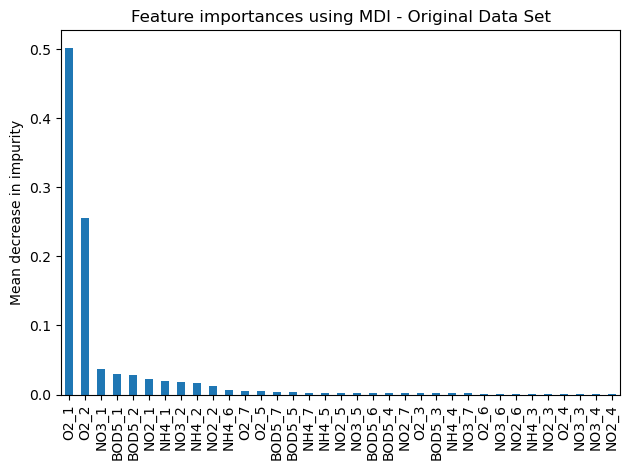

In [15]:
importances = pd.Series(rf.feature_importances_, index=rf.feature_names_in_).sort_values(ascending=False)

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI - Original Data Set")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

* Features that have mostly non-NAN values and are close to target location are more relevant

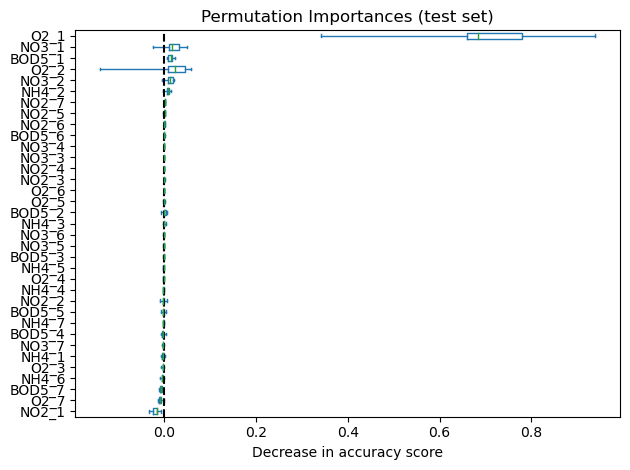

In [16]:
result = permutation_importance(
    rf, X_og_test, y_og_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [17]:
importances.mean().sort_values(ascending=False)

O2_1      0.691427
NO3_1     0.017211
BOD5_1    0.013538
O2_2      0.012264
NO3_2     0.011799
NH4_2     0.007948
NO2_7     0.000834
NO2_5     0.000577
NO2_6     0.000520
BOD5_6    0.000246
NO3_4     0.000059
NO3_3    -0.000142
NO2_4    -0.000149
NO2_3    -0.000205
O2_6     -0.000213
O2_5     -0.000414
BOD5_2   -0.000416
NH4_3    -0.000432
NO3_6    -0.000603
NO3_5    -0.000928
BOD5_3   -0.001076
NH4_5    -0.001203
O2_4     -0.001514
NH4_4    -0.001672
NO2_2    -0.001754
BOD5_5   -0.001810
NH4_7    -0.002023
BOD5_4   -0.002532
NO3_7    -0.002714
NH4_1    -0.002808
O2_3     -0.002866
NH4_6    -0.004195
BOD5_7   -0.007137
O2_7     -0.008655
NO2_1    -0.018698
dtype: float64

In [18]:
df.describe()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,...,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,1749.500000,8.473834,8.216993,9.291581,9.633064,8.065733,5.671581,9.461363,6.547433,0.340525,...,8.710466,3.002243,3.242654,4.816718,4.754389,4.285660,5.968980,7.837995,3.750349,4.068639
std,1010.507298,1.885712,3.040743,6.817822,1.439039,1.463881,2.721399,1.140365,1.663266,0.284751,...,6.438648,2.918355,2.713923,2.009161,1.547491,2.093388,2.576146,3.724861,1.682421,1.894632
min,0.000000,1.300000,0.000000,0.000000,4.900000,2.300000,0.200000,0.000000,0.000000,0.020000,...,0.044000,0.011000,0.000000,0.570000,0.089000,0.850000,2.025000,2.020000,0.364000,1.600000
25%,874.750000,7.470000,7.100000,7.300000,8.770000,6.830000,4.550000,8.980000,5.877500,0.214500,...,4.450000,1.140000,1.780000,3.520000,3.950000,2.290000,4.950000,5.725000,2.684000,2.900000
50%,1749.500000,8.280000,7.890000,8.300000,9.500000,7.980000,5.800000,9.430000,6.430000,0.247000,...,6.054000,1.730000,1.800000,4.600000,4.800000,3.950000,5.725000,7.500000,3.500000,3.700000
75%,2624.250000,9.110000,9.100000,8.700000,9.545000,9.265000,7.015000,10.070000,7.150000,0.370000,...,14.515000,3.025000,4.237500,5.000000,5.400000,4.725000,6.250000,8.400000,4.150000,4.450000
max,3499.000000,65.930000,46.950000,65.950000,16.900000,21.800000,59.400000,40.190000,15.900000,4.200000,...,35.000000,19.355000,27.025000,11.650000,10.700000,19.800000,55.400000,82.450000,19.375000,10.370000


# Find Outliers

We can find outliers just from important features or find outliers from entire dataset.
If they match that is an easy fix. 
If they don't it would depend on whether ornot we zero out all of the features.

In [19]:
#import outlier detection models
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

#baseline score
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
base_score = cross_val_score(rf, X_train, y_train, scoring = 'neg_root_mean_squared_error')
base_score.mean()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-1.5579344245780251

In [20]:
outlier_mods = [('Elliptic', EllipticEnvelope()), ('IF', IsolationForest()), ('LOF', LocalOutlierFactor()), ('SVM', OneClassSVM()), ('SGD', SGDOneClassSVM())]
def outlier_test(df, X_train, y_train): 
    outlier_idx = {}
    for name, model in outlier_mods:
        print(f"Evaluating {name} model...")
        yhat = model.fit_predict(X_train)
        mask = np.where(yhat != -1)
        clean_X_train, clean_y_train = X_train.iloc[mask], y_train.iloc[mask]
        num_outliers = X_train.shape[0] - clean_X_train.shape[0]
        print(f"Total number of outliers removed: {num_outliers}")
        print(f"New Length of X_train: {clean_X_train.shape[0]}")
        outlier_idx[name] = mask
    return outlier_idx

In [21]:
outlier_idx = outlier_test(df, X_train, y_train)

Evaluating Elliptic model...
Total number of outliers removed: 263
New Length of X_train: 2362
Evaluating IF model...
Total number of outliers removed: 67
New Length of X_train: 2558
Evaluating LOF model...
Total number of outliers removed: 95
New Length of X_train: 2530
Evaluating SVM model...
Total number of outliers removed: 1310
New Length of X_train: 1315
Evaluating SGD model...
Total number of outliers removed: 14
New Length of X_train: 2611


In [22]:
def outlier_scorer(outlier_idx, X_train, y_train) :
    outlier_scores = {}
    for name, array in outlier_idx.items():
        print(f"Scoring {name} model without outliers...")
        score = cross_val_score(rf, X_train.iloc[array], y_train.iloc[array],scoring = 'neg_root_mean_squared_error')
        outlier_scores[name] = score.mean()
    return outlier_scores

In [23]:
outlier_scores = outlier_scorer(outlier_idx, X_train, y_train)
print(f'Outlier scores: {outlier_scores}')
print(f'Base Score: {base_score.mean()}')

Scoring Elliptic model without outliers...
Scoring IF model without outliers...
Scoring LOF model without outliers...
Scoring SVM model without outliers...
Scoring SGD model without outliers...
Outlier scores: {'Elliptic': -1.0223029938796047, 'IF': -1.5397485492334855, 'LOF': -1.006870673859216, 'SVM': -0.9500190692728578, 'SGD': -1.5575724371929418}
Base Score: -1.5579344245780251


* Elliptic, LOF and SVM all improve CV score but might be overfit.

In [24]:
#Check common values among models
common_idx = np.unique(np.concatenate((outlier_idx['Elliptic'], outlier_idx['LOF'], outlier_idx['SVM']), axis = 1))
print(f'Length of common dataset: {len(common_idx)}')
print(f'Total Outliers removed: {len(X_train) - len(common_idx)}')

Length of common dataset: 2589
Total Outliers removed: 36


In [25]:
score = cross_val_score(rf, X_train.iloc[common_idx], y_train.iloc[common_idx],scoring = 'neg_root_mean_squared_error')
score.mean()

-1.0191395425447947

* Common Outliers might prevent overfitting

In [26]:
#Test out common_idx model
rf.fit(X_train.iloc[common_idx], y_train.iloc[common_idx])
print("Test set RMSE:", mean_squared_error(y_test, rf.predict(X_test), squared=False))
print("Mean validation RMSE:", -score.mean())

Test set RMSE: 1.1612903041411085
Mean validation RMSE: 1.0191395425447947


* Training set is still overfitting - Try removing the non informative features

# Submission using common outliers

In [27]:
#Combine all sets for submission
train_final = pd.concat([y_train.iloc[common_idx], X_train.iloc[common_idx]], axis=1)
test_final = pd.concat([y_test, X_test], axis = 1)
submission = pd.concat([train_final, test_final])

#Zero out id column
submission.insert(0, 'id', np.zeros(3464))

In [28]:
submission

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
3378,0.0,8.11,9.700,8.40,9.265,9.265,5.01,8.54,5.010,0.530,...,0.70,0.360,0.567,5.100,4.200,4.500,10.000,7.750,5.025,4.20
366,0.0,9.29,7.500,9.40,6.025,4.900,3.29,8.98,6.375,0.240,...,4.58,1.440,0.760,3.150,4.800,5.725,6.075,5.725,3.500,5.70
2171,0.0,7.40,7.400,7.60,9.250,6.170,5.20,4.17,5.280,0.250,...,9.26,2.280,2.480,3.500,4.200,4.500,6.150,5.700,8.250,8.25
2579,0.0,8.12,7.500,8.50,11.475,9.115,8.11,8.98,6.375,0.140,...,20.05,9.530,7.695,10.700,7.300,2.040,2.800,5.800,2.700,2.23
29,0.0,8.59,11.000,8.50,9.545,9.265,3.29,8.43,7.150,0.300,...,2.02,0.636,6.760,5.000,3.300,4.725,3.950,8.400,3.500,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.0,8.12,10.000,8.76,11.475,9.115,8.11,8.98,6.375,0.700,...,2.02,1.070,0.760,3.500,3.300,3.950,5.100,6.750,3.500,3.10
135,0.0,9.49,7.367,40.90,11.475,6.830,1.59,10.07,7.150,0.360,...,2.02,0.636,1.800,3.150,2.520,2.040,5.200,26.500,2.950,2.90
2430,0.0,8.08,9.400,8.50,11.475,9.115,8.11,8.98,6.375,0.040,...,20.05,9.530,7.695,10.700,7.300,2.040,2.800,8.400,2.155,2.23
3082,0.0,9.70,9.700,9.10,9.250,7.240,5.01,10.11,7.980,0.360,...,7.69,5.070,6.420,1.300,2.400,4.950,6.025,6.025,3.290,3.17


In [29]:
submission.to_csv('submission.csv', index = False)